# Mask R-CNN Training



## **1. Installation**

Load your dataset

In [ ]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!git clone https://github.com/pysource7/Mask_RCNN
import sys
sys.path.append("/content/Mask_RCNN/demo")
from train_mask_rcnn_demo import *
%matplotlib inline

In [ ]:
!nvidia-smi

## **2. Image Dataset**

Load your annotated dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [42]:
# Extract Images
images_path = "/content/drive/MyDrive/TFM/Collab/Images/Clear_white_solid"
annotations_path = "/content/drive/MyDrive/TFM/Collab/training_clear_white.json"


In [ ]:
dataset_train = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "train")
dataset_val = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "val")
class_number = dataset_train.count_classes()
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))

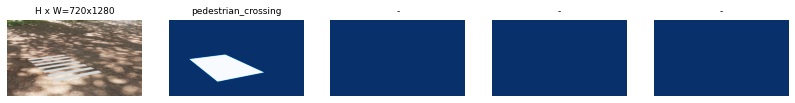

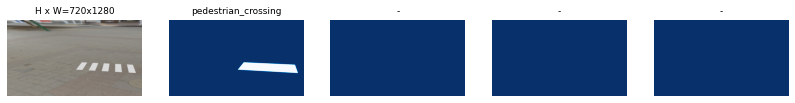

In [44]:
# Load image samples
display_image_samples(dataset_train)

##**3. Training**

Train Mask RCNN on your custom Dataset.

In [ ]:
# Load Configuration
config = CustomConfig(class_number)

config.display()

In [ ]:
model = load_training_model(config)

In [31]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Start Training
# This operation might take a long time.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')

## **4. Detection (test on a random image)**

In [ ]:
# Load Test Model
# The latest trained model will be loaded
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig(class_number)

test_model, inference_config = load_test_model(class_number)

original_image           shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
Trained model result
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  129.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Annotation


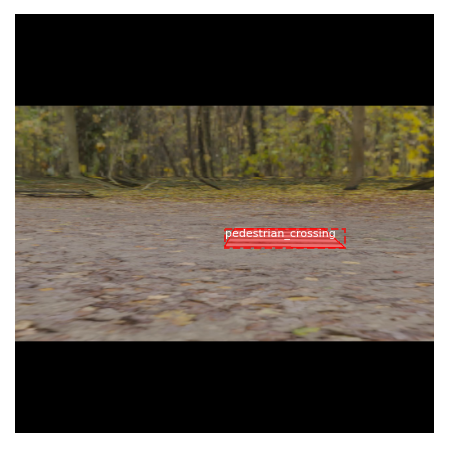

In [60]:
# Test on a random image
test_random_image(test_model, dataset_val, inference_config)

**Find AP@0.5**

In [ ]:
def model_evaluation(dataset_val, test_model, inference_config):
    APs = []
    precisions_ = []
    recalls_ = []
    overlaps_ = []
    print("Testing the model on {} validation images.".format(len(dataset_val.image_ids)))
    for image_id in dataset_val.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = test_model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
        precisions_.append(precisions)
        recalls_.append(recalls)
        overlaps_.append(overlaps)
    return APs, precisions_, recalls_, overlaps_

ap_list, precision_list, recall_list, overlap_list = model_evaluation(dataset_val, test_model, inference_config)
print("mAP: ", np.mean(ap_list))

In [ ]:
def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.
    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)

image_index = random.randint(0, len(dataset_val.image_ids))
plot_precision_recall(np.mean(ap_list), precision_list[image_index], recall_list[image_index])